In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")
import inspect

import numpy as np
import scipy as sp
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from PIL import Image

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp
from sklearn.cluster import KMeans
from matplotlib import cm

from scipy import stats


# 

In [2]:
ImagesFolder = '../../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + f + '.tif' for f in raster_wavelength]
bands_data = []

for f in range(len(raster_Name)):
    raster_dataset = gdal.Open(ImagesFolder+raster_Name[f], gdal.GA_ReadOnly)
    band = raster_dataset.GetRasterBand(1)

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjection()

rows, cols = (raster_dataset.RasterYSize, raster_dataset.RasterXSize)

# WorkingIndex = np.full((10980, 10980), False)
# WorkingIndex[5000:,0:8500] = True


In [3]:
npzfile = np.load('../../../Poe/CompressedData/XData.npz')
X = npzfile['VolumFreeR']
Blue, Green, Red = np.log(6000*X[:,:,1]), np.log(6000*X[:,:,2]), np.log(6000*X[:,:,3])
del X

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [251]:
r2, s, it = mgp.GetNeighboorRegress( Green, Blue, (1000,1000), (3,3), verbose=True)

../../..\my_packages\My_Geoprocess.py:858: RuntimeWarning: invalid value encountered in subtract
  y_norm = y - y_mean


../../..\my_packages\My_Geoprocess.py:856: RuntimeWarning: invalid value encountered in subtract
  x_norm = x - x_mean


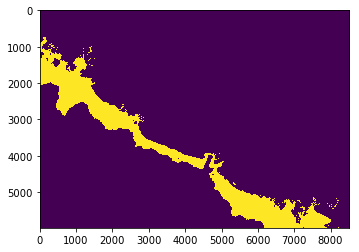

In [148]:
ShapeFolder = '../../Poe/Shapes/'
Lagoon = 'Mask/Lagoon.tif'

ClassifyIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifyIndex = ClassifyIndex.GetRasterBand(1).ReadAsArray(xoff=0, yoff=5000, win_xsize=8500, win_ysize=5980).astype(bool)

plt.imshow(ClassifyIndex)

In [269]:
assert ClassifyIndex.shape==r2.shape
r2[~ClassifyIndex] = np.nan
s[~ClassifyIndex] = np.nan
it[~ClassifyIndex] = np.nan

In [272]:
visuelIt = np.full(it.shape, np.nan)
visuelIt[:,:] = it[:,:]
visuelIt[r2<0.97] = np.nan
visuelIt[s<0] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


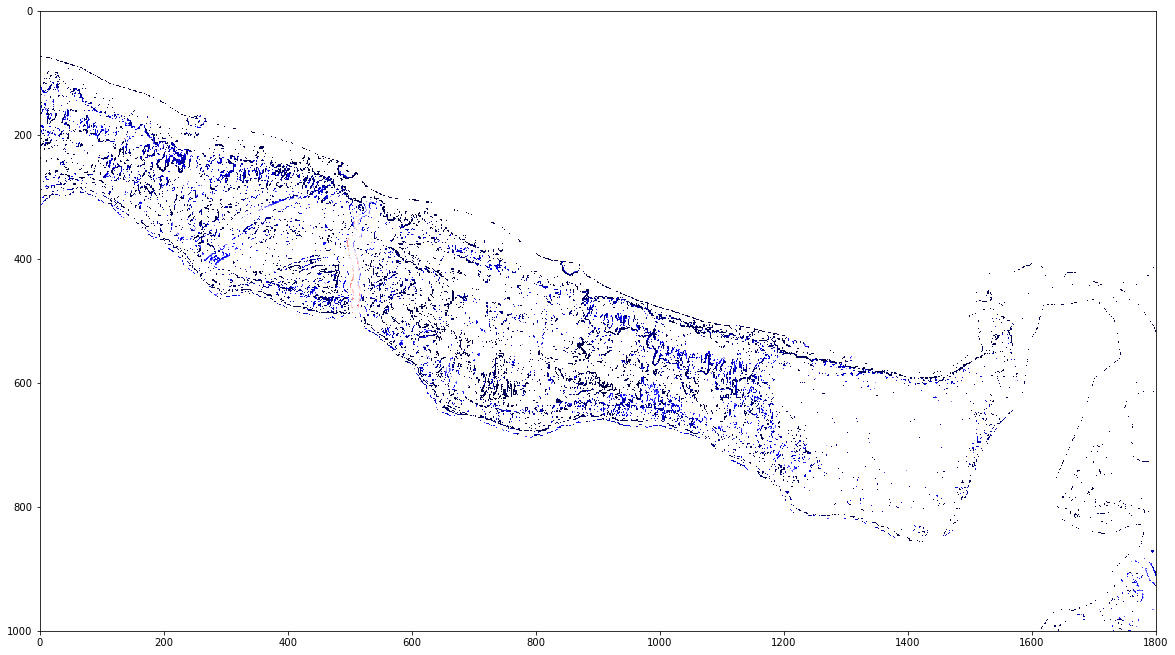

In [273]:
from matplotlib import colors
Meanit = np.nanmean(visuelIt[3500:4500,3000:4800])
Stdit = np.nanstd(visuelIt[3500:4500,3000:4800])

'''cmap = colors.ListedColormap(['blue', 'red'])
bounds=[0,0.96,3]
norm = colors.BoundaryNorm(bounds, cmap.N)'''
plt.figure(figsize=(20,20))
plt.imshow(visuelIt[3500:4500,3000:4800],cmap='seismic', vmin=-3, vmax=5)

In [274]:
nr,nc = np.where(np.logical_and(ClassifyIndex,np.isnan(visuelIt)))
r,c = np.where(np.logical_and(ClassifyIndex,~np.isnan(visuelIt)))

In [275]:
visuelIt[np.logical_and(ClassifyIndex,np.isnan(visuelIt))]=griddata(np.stack((r,c), axis=1), 
                                                                    visuelIt[np.logical_and(ClassifyIndex,~np.isnan(visuelIt))], 
                                                                    (nr,nc), 
                                                                    method='nearest')

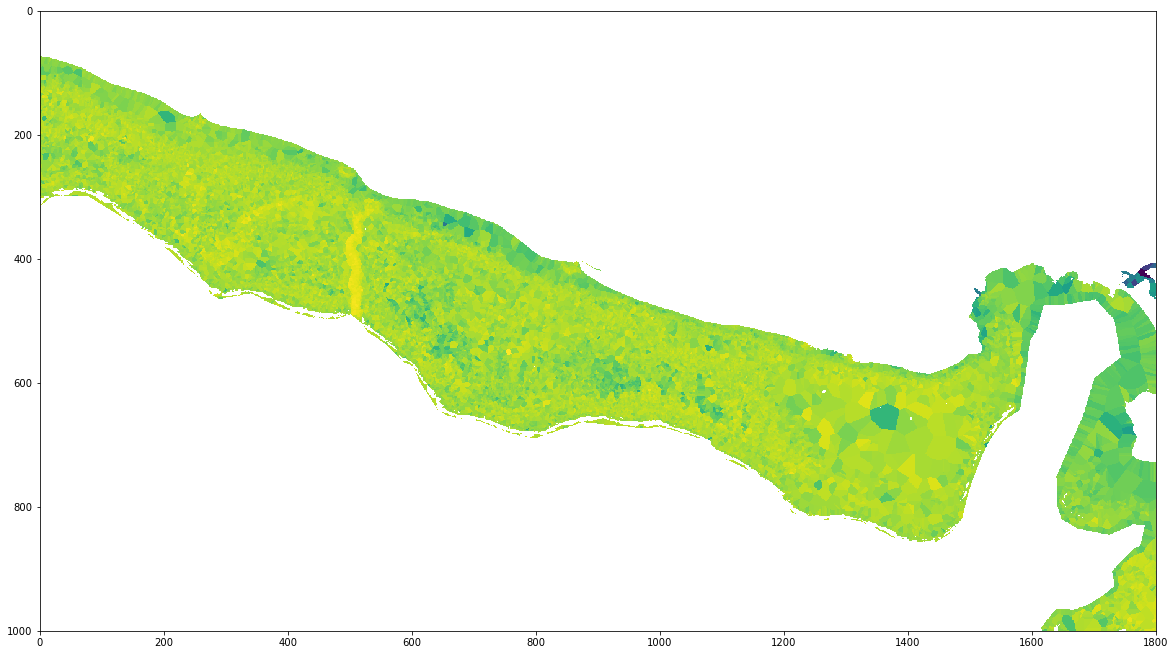

In [276]:
from matplotlib import colors
Meanit = np.nanmean(visuelIt[3500:4500,3000:4800])
Stdit = np.nanstd(visuelIt[3500:4500,3000:4800])

'''cmap = colors.ListedColormap(['blue', 'red'])
bounds=[0,0.96,3]
norm = colors.BoundaryNorm(bounds, cmap.N)'''
plt.figure(figsize=(20,20))
plt.imshow(visuelIt[3500:4500,3000:4800])

In [184]:
visuelIt.shape

(4386863,)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


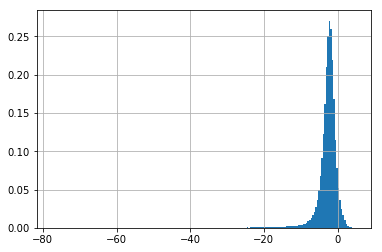

In [260]:
a,b,c = plt.hist(x=it[np.logical_and(s>0, r2>0.95)],bins=200, normed=True)

plt.grid('on')

In [171]:
from scipy.interpolate import griddata


Help on function griddata in module scipy.interpolate.ndgriddata:

griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
    Interpolate unstructured D-dimensional data.
    
    Parameters
    ----------
    points : ndarray of floats, shape (n, D)
        Data point coordinates. Can either be an array of
        shape (n, D), or a tuple of `ndim` arrays.
    values : ndarray of float or complex, shape (n,)
        Data values.
    xi : 2-D ndarray of float or tuple of 1-D array, shape (M, D)
        Points at which to interpolate data.
    method : {'linear', 'nearest', 'cubic'}, optional
        Method of interpolation. One of
    
        ``nearest``
          return the value at the data point closest to
          the point of interpolation.  See `NearestNDInterpolator` for
          more details.
    
        ``linear``
          tesselate the input point set to n-dimensional
          simplices, and interpolate linearly on each simplex.  See
          `Lin

In [93]:
b[np.argsort(a)]

array([ 4.04443155,  4.14077304,  4.0926023 ,  4.06851692,  3.97217543,
        3.94809006,  3.92400469,  3.87583394,  3.85174857,  3.82766319,
        3.77949245,  3.75540708,  4.16485841,  3.7313217 ,  3.68315096,
        3.65906558,  3.63498021,  3.61089484,  3.58680946,  3.56272409,
        3.53863872,  3.49046797,  3.4663826 ,  3.44229723,  3.39412648,
        3.70723633,  4.18894379,  4.83924886,  4.23711453,  0.09443039,
        4.81516348,  4.79107811,  4.76699274,  4.74290736,  4.71882199,
        4.69473662,  4.67065125,  4.64656587,  4.6224805 ,  4.21302916,
        4.57430975,  4.55022438,  4.52613901,  4.50205364,  4.59839513,
        4.47796826,  4.45388289,  4.42979752,  4.40571214,  4.38162677,
        4.3575414 ,  4.33345603,  4.28528528,  4.26119991,  3.15327275,
        3.2014435 ,  3.27369962,  3.29778499,  3.32187036,  3.34595574,
        4.11668767,  3.41821185,  3.80357782,  4.30937065,  3.10510201,
        4.02034618,  3.9962608 ,  3.37004111,  4.86333423,  0.07

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(s[3500:4500,3000:4500])

In [ ]:
np.nanmax(s)